In [5]:
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from Bio.SeqIO import parse
from scipy.spatial.distance import pdist, squareform, euclidean

from utils import (
    prepare_exp_aa_subst, collect_possible_changes, 
    cdn_spectrum_to_matrix, possible_codons, amino_acid_codes,
    get_equilibrium_freqs, get_equilibrium_probabilities,
    prepare_exp_cdn_subst
)

In [6]:
# Assuming you have:
# transition_matrix - 64x64 numpy array
# initial_vector - 1x64 numpy array (or 64x1, will need to transpose if needed)

def simulate_markov(transition_matrix, initial_vector, num_iterations):
    current_state = initial_vector
    data = [current_state]
    for _ in range(num_iterations):
        current_state = np.dot(current_state, transition_matrix)
        data.append(current_state)
        # print(f"Current state after iteration: {current_state[:5]}")
    return data


def simulate_markov_power(transition_matrix, initial_vector, num_iterations):
    powered_matrix = np.linalg.matrix_power(transition_matrix, num_iterations)
    return np.dot(initial_vector, powered_matrix)

## test 2 approaches

In [3]:
clades_spectra = pd.read_csv('data/rates_by_clade.csv')
clades_spectra['Mut'] = clades_spectra['mut_type'].str.replace('to', '>')
spectrum_20A = clades_spectra[clades_spectra['clade'] == '20A'].copy()
spectrum_20A['rate'] /= spectrum_20A['rate'].sum()
spectrum_20A

FileNotFoundError: [Errno 2] No such file or directory: 'data/rates_by_clade.csv'

In [ ]:
from pymutspec.annotation import CodonAnnotation

# def get_equilibrium_freqs(spectrum: pd.DataFrame, rate_col='MutSpec', gc=1):
coda = CodonAnnotation(1)
df_changes = collect_possible_changes(1)
spectrum_dict = spectrum_20A.set_index('Mut')['rate'].to_dict()

df_changes['rate'] = df_changes['sbs'].map(spectrum_dict)

cdn_sbs = df_changes.groupby(['cdn1', 'cdn2'])['rate'].sum()
M = cdn_spectrum_to_matrix(cdn_sbs)
eq_prob = get_equilibrium_probabilities(M).astype(float)

eq_freqs_cdn = pd.Series(dict(zip(possible_codons, eq_prob)))
eq_freqs_cdn.name = 'eq_freq'
eq_freqs_cdn.index.name = 'cdn'
eq_freqs_cdn = eq_freqs_cdn.reset_index()
eq_freqs_cdn['aa'] = eq_freqs_cdn['cdn']\
    .map(coda.translate_codon).map(amino_acid_codes)

eq_freqs_aa = eq_freqs_cdn[eq_freqs_cdn.aa !='*'].groupby('aa')['eq_freq'].sum()
eq_freqs_aa /= eq_freqs_aa.sum()
eq_freqs_aa = eq_freqs_aa.sort_values(ascending=False).reset_index()

eq_cdn1, eq_aa1 = eq_freqs_cdn, eq_freqs_aa

/tmp/ipykernel_556277/1248810473.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  eq_prob = get_equilibrium_probabilities(M).astype(float)


In [ ]:
#CDN
df_changes['rate'] = df_changes['sbs'].map(spectrum_dict)
exp_cdn_subst = cdn_sbs.reset_index()

Mcdn = exp_cdn_subst.pivot(index='cdn1', columns='cdn2', values='rate').fillna(0.)
Mcdn = (Mcdn.T / Mcdn.sum(axis=1)).T
# Mcdn = Mcdn / Mcdn.sum().sum()

aa_init_freqs = np.random.rand(len(Mcdn.columns))
aa_init_freqs = aa_init_freqs / aa_init_freqs.sum()

res_cdn = simulate_markov_power(Mcdn.values, aa_init_freqs, 1000)
# pd.DataFrame({'aa': Mcdn.columns, 'eq2': res_cdn})
res_cdn

array([2.95463048e-03, 3.77796575e-03, 1.46063545e-03, 1.27203193e-02,
       3.77796575e-03, 2.77558383e-03, 1.06875772e-03, 1.68693185e-02,
       1.46063545e-03, 1.06875772e-03, 4.11516605e-04, 6.52328396e-03,
       1.27203193e-02, 1.68693185e-02, 6.52328396e-03, 5.45859816e-02,
       3.77796575e-03, 2.77558383e-03, 1.06875772e-03, 1.68693185e-02,
       2.77558383e-03, 1.72137567e-03, 6.61660340e-04, 1.24869481e-02,
       1.06875772e-03, 6.61660340e-04, 2.54323139e-04, 4.80852885e-03,
       1.68693185e-02, 1.24869481e-02, 4.80852885e-03, 7.52971577e-02,
       1.46063545e-03, 1.06875772e-03, 4.11516605e-04, 6.52328396e-03,
       1.06875772e-03, 6.61660340e-04, 2.54323139e-04, 4.80852885e-03,
       4.11516605e-04, 2.54323139e-04, 9.77525401e-05, 1.85161608e-03,
       6.52328396e-03, 4.80852885e-03, 1.85161608e-03, 2.91229620e-02,
       1.27203193e-02, 1.68693185e-02, 6.52328396e-03, 5.45859816e-02,
       1.68693185e-02, 1.24869481e-02, 4.80852885e-03, 7.52971577e-02,
      

In [4]:
# eq_prob2 = get_equilibrium_probabilities(M).astype(float)
M[:5, :5]

NameError: name 'M' is not defined

In [7]:
Mcdn.sum(1).sum()

np.float64(64.0)

In [8]:
Mcdn = exp_cdn_subst.pivot(index='cdn1', columns='cdn2', values='rate').fillna(0.)
# Mcdn = (Mcdn.T / Mcdn.sum(axis=1)).T
Mcdn = Mcdn / Mcdn.sum().sum()
# Mcdn.values[:5, :5].T

In [9]:
Mcdn.values[:5, :5]

array([[0.        , 0.00016232, 0.00091771, 0.00029227, 0.00016232],
       [0.00040662, 0.        , 0.00015593, 0.00853154, 0.        ],
       [0.00211697, 0.0003465 , 0.        , 0.00675308, 0.        ],
       [0.00018268, 0.00084001, 0.00012772, 0.        , 0.        ],
       [0.00040662, 0.        , 0.        , 0.        , 0.        ]])

In [25]:
def cdn_spectrum_to_matrix2(cdn_sbs):
    '''
    convert dictionary of mutation counts to mutation matrix
    '''
    n = len(possible_codons)
    M = np.zeros((n, n))
    for i1,cdn1 in enumerate(possible_codons):
        for i2,cdn2 in enumerate(possible_codons):
            if cdn1!=cdn2:
                val = cdn_sbs[(cdn1, cdn2)] if (cdn1, cdn2) in cdn_sbs.index else 0.
                M[i2,i1] = val
    # normalize off-diagonal rates (just for standardization, doesn't affect the results)
    # M /= M.sum()
    M /= M.sum(axis=0, keepdims=True)
    # will the diagonal with 'outflow' term to guarantee conservation of probability
    d = M.sum(axis=0)
    np.fill_diagonal(M,-d)
    return M

cdn_sbs = df_changes.groupby(['cdn1', 'cdn2'])['rate'].sum()
M = cdn_spectrum_to_matrix2(cdn_sbs)
eq_prob = get_equilibrium_probabilities(M).astype(float)

eq_freqs_cdn = pd.Series(dict(zip(possible_codons, eq_prob)))
eq_freqs_cdn.name = 'eq_freq'
eq_freqs_cdn.index.name = 'cdn'
eq_freqs_cdn = eq_freqs_cdn.reset_index()

/tmp/ipykernel_556277/160814893.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
  eq_prob = get_equilibrium_probabilities(M).astype(float)


In [26]:
M[0, 1:].sum(), M[0].sum()

(np.float64(0.7747054063269248), np.float64(-0.22529459367307506))

In [29]:
M[:5, :5]

array([[-1.        ,  0.03434637,  0.17698713,  0.04690163,  0.03434637],
       [ 0.03942677, -1.        ,  0.02896914,  0.2156633 ,  0.        ],
       [ 0.22291268,  0.01317085, -1.        ,  0.03278977,  0.        ],
       [ 0.07099388,  0.72065041,  0.56458499, -1.        ,  0.        ],
       [ 0.03942677,  0.        ,  0.        ,  0.        , -1.        ]])

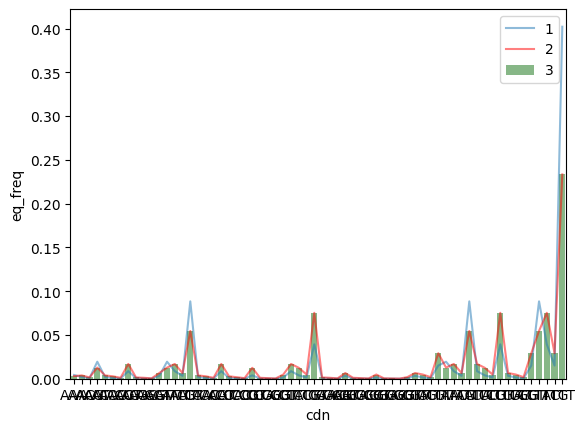

In [28]:
sns.lineplot(eq_cdn1, x='cdn', y='eq_freq', alpha=0.5, label='1')
sns.lineplot(pd.DataFrame({'cdn': Mcdn.columns, 'eq_freq': res_cdn}), 
             x='cdn', y='eq_freq', alpha=0.5, label='2', color='red')
sns.barplot(eq_freqs_cdn, x='cdn', y='eq_freq', alpha=0.5, label='3', color='g')

plt.legend()

## Main

### Load codon counts from refseq

In [7]:
data_cdn_counts = dict()

for rec in parse('./data/refseq_data/cds.fna', 'fasta'):
    if ' ORF1ab polyprotein ' in rec.description or ' ORF1a polyprotein ' in rec.description:
        print(' pass', rec.description)
    else:
        # print(rec.description, len(rec), len(rec) % 3)
        seq = str(rec.seq)
        codons = [seq[i:i+3] for i in range(0, len(rec), 3)]
        assert seq == ''.join(codons)
        gene = ' '.join(rec.description.split()[1:]).split(' [organism=')[0]

        print(gene, codons[-1], len(codons))

        data_cdn_counts[gene] = dict(Counter(codons))

3C-like proteinase [polyprotein=ORF1ab polyprotein] CAA 306
nsp6 [polyprotein=ORF1ab polyprotein] CAG 290
nsp7 [polyprotein=ORF1ab polyprotein] CAA 83
nsp8 [polyprotein=ORF1ab polyprotein] CAG 198
nsp9 [polyprotein=ORF1ab polyprotein] CAA 113
nsp10 [polyprotein=ORF1ab polyprotein] CAG 139
RNA-dependent RNA polymerase [polyprotein=ORF1ab polyprotein] CAG 932
nsp11 [polyprotein=ORF1a polyprotein] GTG 13
helicase [polyprotein=ORF1ab polyprotein] CAA 601
3'-to-5' exonuclease [polyprotein=ORF1ab polyprotein] CAG 527
endoRNAse [polyprotein=ORF1ab polyprotein] CAA 346
2'-O-ribose methyltransferase [polyprotein=ORF1ab polyprotein] AAC 298
surface glycoprotein TAA 1274
ORF3a protein TAA 276
envelope protein TAA 76
membrane glycoprotein TAA 223
 pass NC_045512.2:266-13468,13468-21555 ORF1ab polyprotein [organism=Severe acute respiratory syndrome coronavirus 2] [isolate=Wuhan-Hu-1]
 pass NC_045512.2:266-13483 ORF1a polyprotein [organism=Severe acute respiratory syndrome coronavirus 2] [isolate=Wu

In [8]:
cdn_counts_df = pd.DataFrame(data_cdn_counts).T.fillna(0).astype(int)
cdn_counts_df.to_csv('./data/refseq_data/codon_counts.csv')
cdn_counts_df.head()

,AGT,GGT,TTT,AGA,AAA,ATG,GCA,TTC,CCA,TCT,...,TCC,AGC,GCG,GGG,CCG,TCG,CGG,TAA,TGA,TAG
3C-like proteinase [polyprotein=ORF1ab polyprotein],3,17,12,3,3,10,3,5,5,7,...,0,0,0,0,0,0,0,0,0,0
nsp6 [polyprotein=ORF1ab polyprotein],4,11,17,6,8,17,5,5,1,7,...,1,1,0,0,0,0,0,0,0,0
nsp7 [polyprotein=ORF1ab polyprotein],0,1,1,1,4,4,1,0,0,3,...,1,0,0,0,0,0,0,0,0,0
nsp8 [polyprotein=ORF1ab polyprotein],5,3,4,3,8,9,10,1,2,5,...,1,0,0,0,0,0,0,0,0,0
nsp9 [polyprotein=ORF1ab polyprotein],3,6,3,2,4,2,2,1,1,1,...,1,0,1,0,0,0,0,0,0,0


In [9]:
cdn_counts_dct = cdn_counts_df.sum(0).to_dict()

In [10]:
cdn_counts_df.sum(axis=1).sort_values(ascending=False)

nsp3 [polyprotein=ORF1ab polyprotein]                             1945
surface glycoprotein                                              1274
RNA-dependent RNA polymerase [polyprotein=ORF1ab polyprotein]      932
nsp2 [polyprotein=ORF1ab polyprotein]                              638
helicase [polyprotein=ORF1ab polyprotein]                          601
3'-to-5' exonuclease [polyprotein=ORF1ab polyprotein]              527
nsp4 [polyprotein=ORF1ab polyprotein]                              500
nucleocapsid phosphoprotein                                        420
endoRNAse [polyprotein=ORF1ab polyprotein]                         346
3C-like proteinase [polyprotein=ORF1ab polyprotein]                306
2'-O-ribose methyltransferase [polyprotein=ORF1ab polyprotein]     298
nsp6 [polyprotein=ORF1ab polyprotein]                              290
ORF3a protein                                                      276
membrane glycoprotein                                              223
nsp8 [

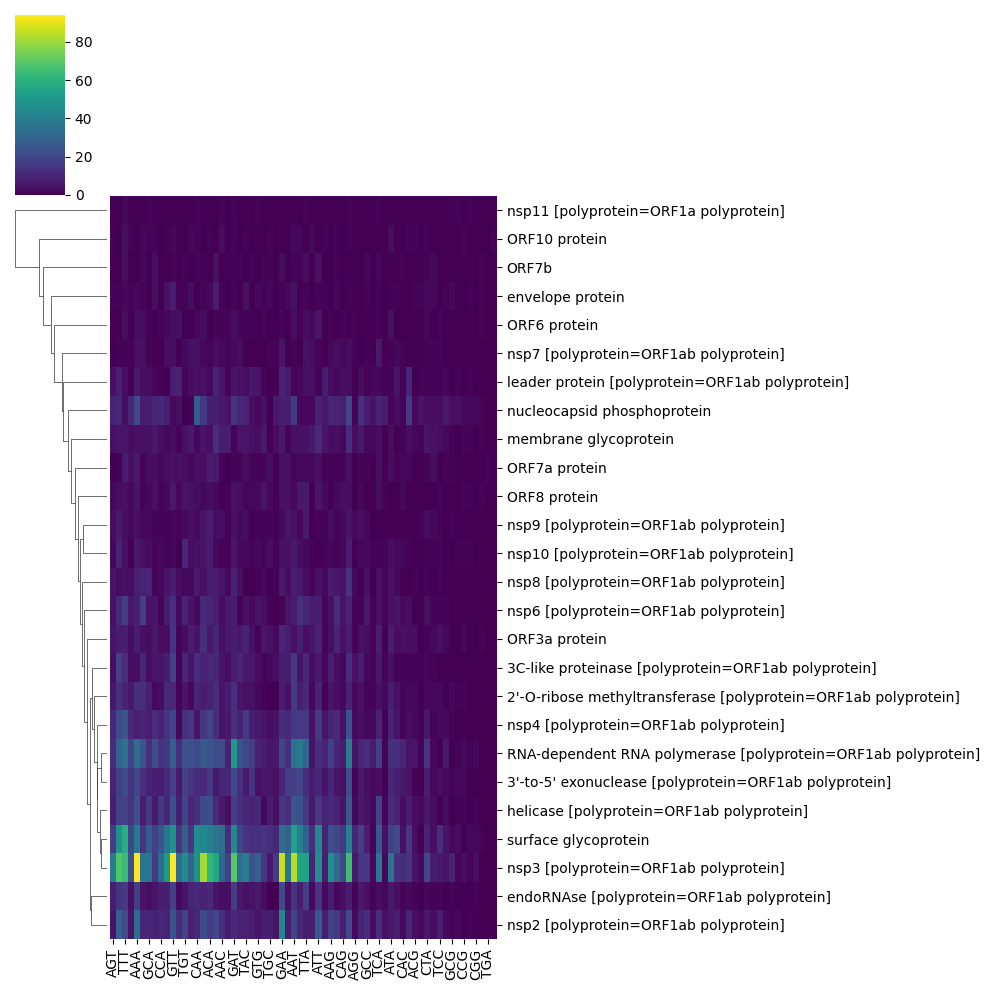

In [45]:
sns.clustermap(cdn_counts_df, cmap='viridis', figsize=(10, 10), metric='cosine',
               col_cluster=False, row_cluster=True, )

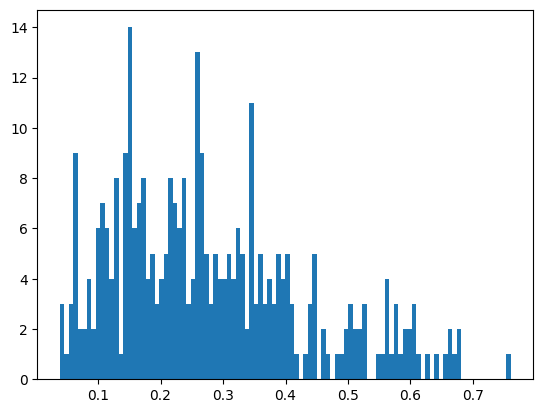

In [46]:
plt.hist(pdist(cdn_counts_df, 'cosine'), bins=100);

### Load matrix

In [11]:
clades_spectra = pd.read_csv('data/bloom_etal/rates_by_clade.csv').query('subset == "all"')
clades_spectra['Mut'] = clades_spectra['mut_type'].str.replace('to', '>')
spectrum_20A = clades_spectra[clades_spectra['clade'] == '20A'].copy()
spectrum_20A['rate'] /= spectrum_20A['rate'].sum()
spectrum_20A

,subset,clade,mut_type,count,total_count,fraction,parent_nt,parent_nt_frac,rate,Mut
0,all,20A,AtoC,305,18970,0.016078,A,0.289560,0.007540,A>C
1,all,20A,AtoG,1778,18970,0.093727,A,0.289560,0.043953,A>G
2,all,20A,AtoT,588,18970,0.030996,A,0.289560,0.014536,A>T
3,all,20A,CtoA,384,18970,0.020242,C,0.135130,0.020341,C>A
4,all,20A,CtoG,135,18970,0.007117,C,0.135130,0.007151,C>G
5,all,20A,CtoT,7840,18970,0.413280,C,0.135130,0.415293,C>T
6,all,20A,GtoA,878,18970,0.046284,G,0.064585,0.097310,G>A
7,all,20A,GtoC,140,18970,0.007380,G,0.064585,0.015516,G>C
8,all,20A,GtoT,2906,18970,0.153190,G,0.064585,0.322075,G>T
9,all,20A,TtoA,639,18970,0.033685,T,0.510720,0.008956,T>A


In [12]:
possible_aa = list(amino_acid_codes.values())[:20]

In [13]:
eq_freq_df, _ = get_equilibrium_freqs(spectrum_20A, 'rate', gc=1)
eq_freq_vec_cdn = eq_freq_df.set_index('cdn').loc[possible_codons, 'eq_freq'].values
eq_freq_vec_aa = eq_freq_df.groupby('aa')['eq_freq'].sum().loc[possible_aa].values
eq_freq_vec_aa

array([0.00693951, 0.0089017 , 0.01674627, 0.00780098, 0.03435456,
       0.00493996, 0.00196219, 0.00276877, 0.01965224, 0.0846124 ,
       0.19262164, 0.00455425, 0.00669687, 0.30636098, 0.01739169,
       0.11614326, 0.02459221, 0.00195146, 0.07170198, 0.04300289])

### AA

In [14]:
_, Maa = prepare_exp_aa_subst(spectrum_20A)
Maa = (Maa.T / Maa.sum(axis=1)).T

In [15]:
Maa

aa2,Ala,Arg,Asn,Asp,Cys,Gln,Glu,Gly,His,Ile,Leu,Lys,Met,Phe,Pro,Ser,Thr,Trp,Tyr,Val
aa1,,,,,,,,,,,,,,,,,,,,
Ala,0.221693,0.000000,0.000000,0.009019,0.000000,0.000000,0.009019,0.006342,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013760,0.285607,0.086291,0.000000,0.000000,0.368270
Arg,0.000000,0.214378,0.000000,0.000000,0.148752,0.034855,0.000000,0.020866,0.034855,0.057681,0.230725,0.034855,0.057681,0.000000,0.011116,0.071700,0.005558,0.076979,0.000000,0.000000
Asn,0.000000,0.000000,0.597633,0.115183,0.000000,0.000000,0.000000,0.000000,0.019758,0.038093,0.000000,0.056297,0.000000,0.000000,0.000000,0.115183,0.019758,0.000000,0.038093,0.000000
Asp,0.010047,0.000000,0.129666,0.303882,0.000000,0.000000,0.028626,0.058568,0.020676,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.429167,0.019369
Cys,0.000000,0.056210,0.000000,0.000000,0.314091,0.000000,0.000000,0.008976,0.000000,0.000000,0.000000,0.000000,0.000000,0.443585,0.000000,0.033705,0.000000,0.009413,0.134022,0.000000
Gln,0.000000,0.127776,0.000000,0.000000,0.000000,0.205332,0.020789,0.000000,0.522793,0.000000,0.042258,0.059133,0.000000,0.000000,0.021918,0.000000,0.000000,0.000000,0.000000,0.000000
Glu,0.017562,0.000000,0.000000,0.418880,0.000000,0.036142,0.164519,0.102379,0.000000,0.000000,0.000000,0.226660,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033858
Gly,0.014930,0.061746,0.000000,0.046816,0.154950,0.000000,0.046816,0.240551,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.046816,0.000000,0.077475,0.000000,0.309901
His,0.000000,0.057959,0.026823,0.009430,0.000000,0.028328,0.000000,0.000000,0.300722,0.000000,0.019168,0.000000,0.000000,0.000000,0.009942,0.000000,0.000000,0.000000,0.547628,0.000000


In [16]:
aa_init_freqs = {'Met': 207,
 'Glu': 442,
 'Ser': 661,
 'Leu': 930,
 'Val': 781,
 'Pro': 394,
 'Gly': 576,
 'Phe': 500,
 'Asn': 532,
 'Lys': 562,
 'Thr': 718,
 'His': 189,
 'Gln': 365,
 'Arg': 350,
 'Asp': 511,
 'Ala': 658,
 'Cys': 296,
 'Tyr': 448,
 'Ile': 513,
 'Trp': 111}

aa_init_freqs = np.array([aa_init_freqs[x] for x in Maa.columns])
aa_init_freqs = aa_init_freqs / aa_init_freqs.sum()
aa_init_freqs

array([0.06752874, 0.03591954, 0.0545977 , 0.05244253, 0.03037767,
       0.03745895, 0.04536125, 0.0591133 , 0.01939655, 0.05264778,
       0.09544335, 0.05767652, 0.02124384, 0.05131363, 0.04043514,
       0.06783662, 0.07368637, 0.01139163, 0.04597701, 0.08015189])

In [13]:
for i in range(10):
    d = euclidean(simulate_markov_power(Maa.values, aa_init_freqs, i), eq_freq_vec_aa)
    print(i, d)

res_aa = simulate_markov_power(Maa.values, aa_init_freqs, 10000)

euclidean(res_aa, eq_freq_vec_aa)

0 0.31608854463344643
1 0.23242599638175718
2 0.17588523350227162
3 0.1406227159832762
4 0.11677195009423884
5 0.09975555190004252
6 0.08722028491079847
7 0.0778466424960731
8 0.07082067026647393
9 0.06558288392847103


0.05230767846184161

In [16]:
values, vectors = np.linalg.eig(Maa.values.T)
pi = vectors[:, np.isclose(values, 1)].real
pi = pi / pi.sum()
pi.flatten()

array([0.00620843, 0.00983195, 0.03107591, 0.00926792, 0.02740472,
       0.00274277, 0.00178447, 0.00426784, 0.01816612, 0.11534034,
       0.20627221, 0.00542765, 0.0147691 , 0.2976682 , 0.01646474,
       0.08219259, 0.02845308, 0.00184109, 0.0770432 , 0.04377766])

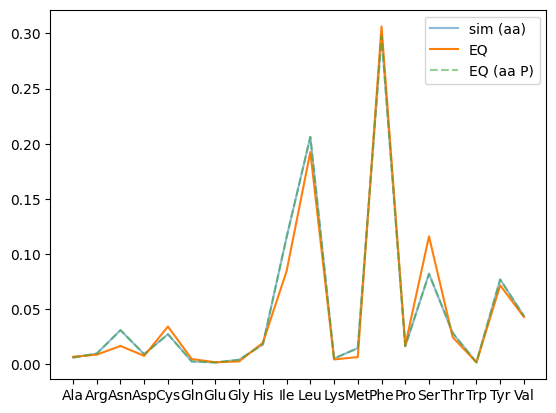

In [17]:
plt.plot(res_aa, label='sim (aa)', alpha=0.5)
plt.plot(eq_freq_vec_aa, label='EQ')
plt.plot(pi.flatten(), label='EQ (aa P)', linestyle='--', alpha=0.5)
plt.xticks(range(20), possible_aa)
plt.legend()

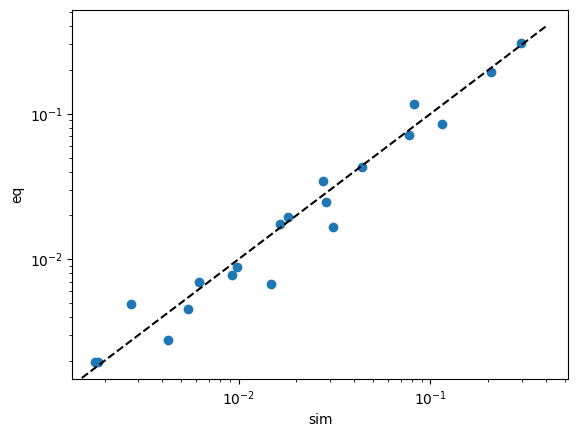

In [18]:
plt.scatter(res_aa, eq_freq_vec_aa)
plt.plot([0, 0.4], [0, 0.4], 'k--')
plt.xlabel('sim')
plt.ylabel('eq')
plt.xscale('log')
plt.yscale('log')

In [17]:
def simulate_markov_continual(transition_matrix, initial_vector, num_iterations, delta_t=0.01):
    pi = initial_vector.copy()
    data = [pi.copy()]
    Q = transition_matrix.copy()
    Q = Q - np.diag(np.sum(Q, axis=1))  # Convert to infinitesimal generator
    for _ in range(num_iterations):
        pi_new = pi + delta_t * (pi @ Q)
        pi_new = pi_new / pi_new.sum()
        data.append(pi_new.copy())
        if np.linalg.norm(pi_new - pi) < 1e-8:
            break
        pi = pi_new
    return data

In [18]:
sim_data = simulate_markov_continual(Maa.values, aa_init_freqs, 10, delta_t=0.01)
sim_data_df = pd.DataFrame(sim_data, columns=Maa.columns.values)
sim_data_df.index.name = 'replica'
sim_data_df_long = sim_data_df.melt(ignore_index=False, value_name='freq', var_name='aa').reset_index()
sim_data_df_long

,replica,aa,freq
0,0,Ala,0.067529
1,1,Ala,0.067119
2,2,Ala,0.066711
3,3,Ala,0.066307
4,4,Ala,0.065905
...,...,...,...
215,6,Val,0.080346
216,7,Val,0.080371
217,8,Val,0.080395
218,9,Val,0.080417


In [19]:
ref_freq_df = pd.DataFrame(
    {'replica':0, 'freq': dict(zip(possible_aa, aa_init_freqs))})\
        .reset_index(names='aa')
ref_freq_df.head()

,aa,replica,freq
0,Ala,0,0.067529
1,Arg,0,0.035920
2,Asn,0,0.054598
3,Asp,0,0.052443
4,Cys,0,0.030378


In [20]:
aa_content25 = pd.read_csv('./data/mean_aa_content_2025.csv', header=None, index_col=0)[1]
aa_content25 /= aa_content25.sum()
df_aa_content25 = aa_content25.sort_index().reset_index()
df_aa_content25.columns = ['aa', 'freq']
df_aa_content25['replica'] = -0.5
aa_content25vec = df_aa_content25['freq'].values
df_aa_content25

,aa,freq,replica
0,Ala,0.066920,-0.5
1,Arg,0.035798,-0.5
2,Asn,0.054159,-0.5
3,Asp,0.052431,-0.5
4,Cys,0.030503,-0.5
5,Gln,0.036961,-0.5
6,Glu,0.045344,-0.5
7,Gly,0.058903,-0.5
8,His,0.019772,-0.5
9,Ile,0.053464,-0.5


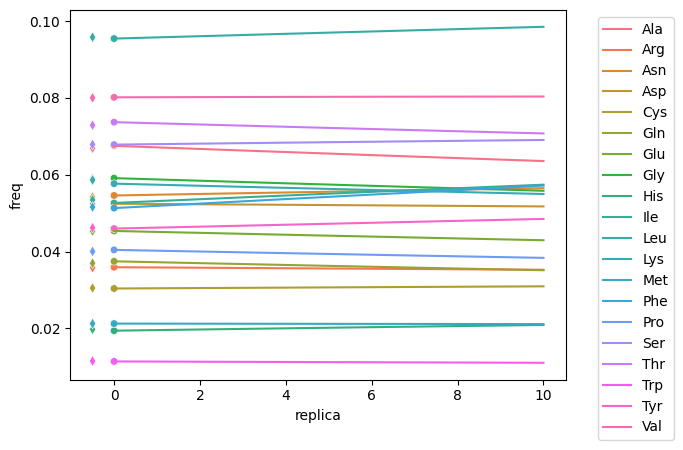

In [21]:
sns.lineplot(sim_data_df_long, x='replica', y='freq', hue='aa')
sns.scatterplot(ref_freq_df, hue='aa', x='replica', y='freq', legend=False, s=30)
sns.scatterplot(df_aa_content25, hue='aa', x='replica', y='freq', legend=False, s=30, marker='d')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [21]:
for i, p in enumerate(simulate_markov_continual(Maa.values, aa_init_freqs, 30, delta_t=0.0005)):
    print(i, np.linalg.norm(p - aa_content25.loc[Maa.columns.values].values)*1000)

0 1.9038514931114563
1 1.8721933824719008
2 1.8419852884280874
3 1.8132981397775598
4 1.7862036557880494
5 1.7607737763159093
6 1.7370800044762071
7 1.7151926655107077
8 1.6951800898960716
9 1.6771077336688682
10 1.6610372541515264
11 1.6470255643785687
12 1.635123894091057
13 1.6253768886881077
14 1.6178217795016439
15 1.6124876587754187
16 1.6093948905121103
17 1.60855468384435
18 1.6099688489787911
19 1.6136297474980443
20 1.6195204395361293
21 1.6276150208530047
22 1.6378791339376895
23 1.6502706297021992
24 1.6647403506546194
25 1.6812330029880986
26 1.69968808386796
27 1.7200408311790232
28 1.7422231657619776
29 1.7661646002560714
30 1.791793093568919


In [22]:
df_change = pd.DataFrame([
    aa_init_freqs,
    simulate_markov_continual(Maa.values, aa_init_freqs, 18, delta_t=0.0005)[-1],
    aa_content25.loc[Maa.columns.values],
], index=['refseq', 'sim1', 'gisaid25'], columns=Maa.columns.values
).T

# df_change['PE'] = (df_change['sim1'] - df_change['refseq']) / df_change['refseq']

df_change['PE_exp'] = (df_change['sim1'] - df_change['refseq']) / df_change['refseq']*100
# df_change['PE_exp'] = df_change['PE_exp'] / df_change['PE_exp'].abs()
df_change['PE_obs'] = (df_change['gisaid25'] - df_change['refseq']) / df_change['refseq']*100
# df_change['PE_obs'] = df_change['PE_obs'] / df_change['PE_obs'].abs()
df_change['correct_direction'] = df_change['PE_exp'].gt(0) == df_change['PE_obs'].gt(0)# & \
    # df_change['PE_obs'].abs().gt(0.5)
df_change['PEdelta'] = (df_change['PE_exp'] - df_change['PE_obs']).abs()
df_change['err'] = df_change['PEdelta'] / df_change['PE_obs'].abs()
df_change['correct_direction'] = df_change['PEdelta'] < 1

df_change

,refseq,sim1,gisaid25,PE_exp,PE_obs,correct_direction,PEdelta,err
Ala,0.067529,0.067161,0.066920,-0.545023,-0.900926,True,0.355903,0.395041
Arg,0.035920,0.035861,0.035798,-0.163341,-0.337612,True,0.174271,0.516188
Asn,0.054598,0.054774,0.054159,0.322995,-0.803272,False,1.126267,1.402099
Asp,0.052443,0.052385,0.052431,-0.108789,-0.021631,True,0.087158,4.029225
Cys,0.030378,0.030434,0.030503,0.184982,0.413500,True,0.228518,0.552644
Gln,0.037459,0.037241,0.036961,-0.582492,-1.328163,True,0.745671,0.561431
Glu,0.045361,0.045138,0.045344,-0.492166,-0.037280,True,0.454885,12.201746
Gly,0.059113,0.058812,0.058903,-0.509820,-0.356420,True,0.153400,0.430392
His,0.019397,0.019536,0.019772,0.720453,1.933841,False,1.213389,0.627450
Ile,0.052648,0.053087,0.053464,0.834024,1.550883,True,0.716859,0.462227


In [19]:
df_change['err'].mean()

np.float64(1.6546705090213845)

<Axes: >

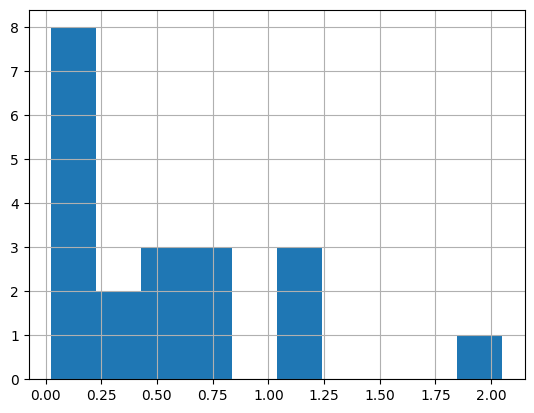

In [20]:
df_change['PEdelta'].hist()

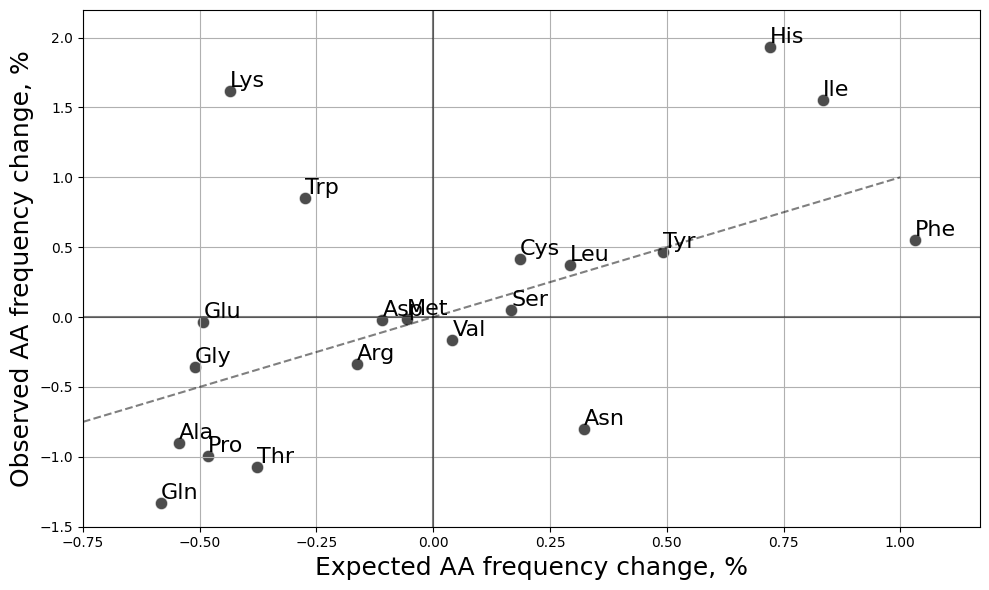

In [ ]:
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(df_change, x='PE_exp', y='PE_obs', 
                s=80, color='black', alpha=0.7,
                # style='correct_direction', hue='correct_direction',
                # markers={True: 'o', False: 'X'}, legend=False,
                # palette={True: 'green', False: 'red'},
)
plt.plot([-0.75, 1], [-0.75, 1], 'k--', alpha=0.5)
for aa, row in df_change.iterrows():
    plt.text(row['PE_exp'], row['PE_obs'], aa, fontsize=16, ha='left', va='bottom')
plt.grid()
# plt.xlabel('Predicted amino acid frequency change, %')
# plt.ylabel('Observed amino acid frequency change, %')
plt.xlabel('Expected AA frequency change, %', fontsize=18)
plt.ylabel('Observed AA frequency change, %', fontsize=18)
ybound = ax.get_ylim()
xbound = ax.get_xlim()
ybound = [-1.5, ybound[1] + 0.1]
xbound = [-0.75, xbound[1] + 0.05]
plt.vlines(0, *ybound, color='k', alpha=0.5)
plt.hlines(0, *xbound, color='k', alpha=0.5)
ax.set_xlim(xbound)
ax.set_ylim(ybound)
plt.tight_layout()
plt.savefig('./figures/aa_freqs_change_sim.pdf', bbox_inches='tight')
plt.show()

In [23]:
aa_content25total = pd.read_csv('./data/aa_content_2025.csv', index_col=0)
aa_content25total_freqs = (aa_content25total.T / aa_content25total.sum(axis=1)).T
aa_content25total_freqs_wide = aa_content25total_freqs.melt(
    ignore_index=False, value_name='gisaid25', var_name='aa')
aa_content25total_freqs_wide['refseq'] = aa_content25total_freqs_wide['aa']\
    .map(df_change['refseq'].to_dict())
aa_content25total_freqs_wide['sim1'] = aa_content25total_freqs_wide['aa']\
    .map(df_change['sim1'].to_dict())
df_change_total = aa_content25total_freqs_wide.copy()


df_change_total['PE_exp'] = (df_change_total['sim1'] - df_change_total['refseq']) / df_change_total['refseq']*100
df_change_total['PE_obs'] = (df_change_total['gisaid25'] - df_change_total['refseq']) / df_change_total['refseq']*100

df_change_total

,aa,gisaid25,refseq,sim1,PE_exp,PE_obs
Accession ID,,,,,,
EPI_ISL_19674224,Pro,0.040025,0.040435,0.040240,-0.482599,-1.015228
EPI_ISL_19674372,Pro,0.040025,0.040435,0.040240,-0.482599,-1.015228
EPI_ISL_19675602,Pro,0.040025,0.040435,0.040240,-0.482599,-1.015228
EPI_ISL_19674356,Pro,0.040127,0.040435,0.040240,-0.482599,-0.761421
EPI_ISL_19674361,Pro,0.039922,0.040435,0.040240,-0.482599,-1.269036
...,...,...,...,...,...,...
EPI_ISL_19885825,Met,0.021244,0.021244,0.021232,-0.055539,0.000000
EPI_ISL_19885820,Met,0.021141,0.021244,0.021232,-0.055539,-0.483092
EPI_ISL_19885830,Met,0.021244,0.021244,0.021232,-0.055539,0.000000


In [29]:
quantiles = df_change_total.groupby('aa')[['PE_exp', 'PE_obs']].quantile([0.25, 0.5, 0.75])
quantiles.index.names = ['aa', 'quantile']
quantiles = quantiles.reset_index()
quantiles.head()

,aa,quantile,PE_exp,PE_obs
0,Ala,0.25,-0.545023,-0.911854
1,Ala,0.50,-0.545023,-0.911854
2,Ala,0.75,-0.545023,-0.759878
3,Arg,0.25,-0.163341,-0.571429
4,Arg,0.50,-0.163341,-0.285714


In [34]:
gr['PE_obs']

0   -0.911854
1   -0.911854
2   -0.759878
Name: PE_obs, dtype: float64

In [76]:
losers = ['Pro', 'Arg', 'Ala', 'Gly', 'Thr']
gainers = ['Ser', 'Leu', 'Val', 'Ile', 'Cys', 'Tyr', 'Phe']

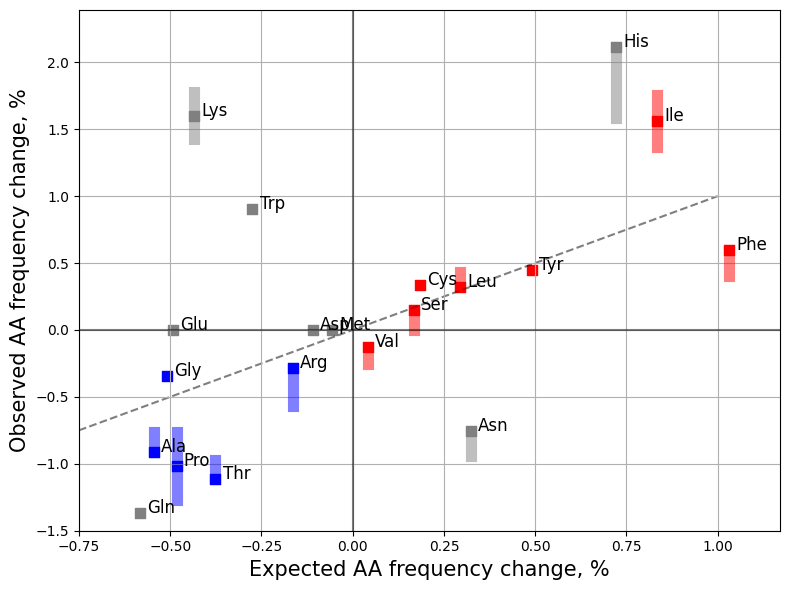

In [83]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

for aa, gr in quantiles.groupby('aa'):
    eq1, eq2, eq3 = gr['PE_exp'].values
    oq1, oq2, oq3 = gr['PE_obs'].values

    if aa in losers:
        color = 'blue'
    elif aa in gainers:
        color = 'red'
    else:
        color = 'gray'
    plt.plot(gr['PE_exp'], gr['PE_obs'], '-', color=color, label=aa, alpha=0.5, linewidth=8)
    plt.scatter(eq2, oq2,  s=50, marker='s', c=color)
    plt.text(eq2+0.02, oq2, aa, fontsize=12, ha='left', va='baseline')


ax.plot([-0.75, 1], [-0.75, 1], 'k--', alpha=0.5, zorder=1)
plt.grid()
plt.xlabel('Expected AA frequency change, %', fontsize=15)
plt.ylabel('Observed AA frequency change, %', fontsize=15)
ybound = ax.get_ylim()
xbound = ax.get_xlim()
ybound = [-1.5, ybound[1] + 0.1]
xbound = [-0.75, xbound[1] + 0.05]
plt.vlines(0, *ybound, color='k', alpha=0.5)
plt.hlines(0, *xbound, color='k', alpha=0.5)
ax.set_xlim(xbound)
ax.set_ylim(ybound)
plt.tight_layout()
plt.savefig('./figures/aa_freqs_change_sim.pdf', bbox_inches='tight')
plt.show()

### CDN

In [33]:
# TEST

transition_matrix = np.array([
    [0.25, 0.5, 0.25],
    [0, 0.5, 0.5],
    [0.33, 0.33, 0.34]
])
initial_vector = np.array([0, 0.5, 0.5])  # Starting in state 0
simulate_markov_power(transition_matrix, initial_vector, 1)

array([0.165, 0.415, 0.42 ])

In [34]:
def prepare_exp_cdn_subst(spectrum: pd.DataFrame, rate_col='rate', gc=1, save_path=None):
    df_changes = collect_possible_changes(gc=gc)
    spectrum_dict = spectrum.set_index('Mut')[rate_col].to_dict()

    df_changes['rate'] = df_changes['sbs'].map(spectrum_dict)

    ## Calculate expected AA substitutions matrix
    exp_cdn_subst = df_changes[(df_changes.cdn1 != '*')&(df_changes.cdn2 != '*')]\
        .groupby(['cdn1', 'cdn2'])['rate'].sum().reset_index()
    
    if save_path:
        exp_cdn_subst.to_csv(save_path, float_format='%g', index=False)
    exp_cdn_subst_matrix = exp_cdn_subst.pivot(index='cdn1', columns='cdn2', values='rate').fillna(0.)
    exp_cdn_subst_matrix = exp_cdn_subst_matrix.loc[possible_codons, possible_codons]
    return exp_cdn_subst, exp_cdn_subst_matrix

In [35]:
_, exp_cdn_subst_matrix = prepare_exp_cdn_subst(spectrum_20A, 'rate', 1)
exp_cdn_subst_matrix = (exp_cdn_subst_matrix.T / exp_cdn_subst_matrix.sum(1)).T
# np.fill_diagonal(exp_cdn_subst_matrix, 0)
# exp_cdn_subst_matrix /= exp_cdn_subst_matrix.sum(axis=1)

In [36]:
values, vectors = np.linalg.eig(exp_cdn_subst_matrix.values.T)
pi = vectors[:, np.isclose(values, 1)].real
pi = pi / pi.sum()
pi.flatten()

array([2.95463048e-03, 3.77796575e-03, 1.46063545e-03, 1.27203193e-02,
       3.77796575e-03, 2.77558383e-03, 1.06875772e-03, 1.68693185e-02,
       1.46063545e-03, 1.06875772e-03, 4.11516605e-04, 6.52328396e-03,
       1.27203193e-02, 1.68693185e-02, 6.52328396e-03, 5.45859816e-02,
       3.77796575e-03, 2.77558383e-03, 1.06875772e-03, 1.68693185e-02,
       2.77558383e-03, 1.72137567e-03, 6.61660340e-04, 1.24869481e-02,
       1.06875772e-03, 6.61660340e-04, 2.54323139e-04, 4.80852885e-03,
       1.68693185e-02, 1.24869481e-02, 4.80852885e-03, 7.52971577e-02,
       1.46063545e-03, 1.06875772e-03, 4.11516605e-04, 6.52328396e-03,
       1.06875772e-03, 6.61660340e-04, 2.54323139e-04, 4.80852885e-03,
       4.11516605e-04, 2.54323139e-04, 9.77525401e-05, 1.85161608e-03,
       6.52328396e-03, 4.80852885e-03, 1.85161608e-03, 2.91229620e-02,
       1.27203193e-02, 1.68693185e-02, 6.52328396e-03, 5.45859816e-02,
       1.68693185e-02, 1.24869481e-02, 4.80852885e-03, 7.52971577e-02,
      

In [37]:
exp_cdn_subst_matrix.sum(1)

cdn1
AAA    1.0
AAC    1.0
AAG    1.0
AAT    1.0
ACA    1.0
      ... 
TGT    1.0
TTA    1.0
TTC    1.0
TTG    1.0
TTT    1.0
Length: 64, dtype: float64

In [38]:
Q = exp_cdn_subst_matrix.values
Q = Q - np.diag(np.sum(Q, axis=1))  # Convert to infinitesimal generator

values, vectors = np.linalg.eig(Q.T)
pi2 = vectors[:, np.isclose(values, 0)].real
pi2 = pi2 / pi2.sum()
pi2.flatten()

array([2.95463048e-03, 3.77796575e-03, 1.46063545e-03, 1.27203193e-02,
       3.77796575e-03, 2.77558383e-03, 1.06875772e-03, 1.68693185e-02,
       1.46063545e-03, 1.06875772e-03, 4.11516605e-04, 6.52328396e-03,
       1.27203193e-02, 1.68693185e-02, 6.52328396e-03, 5.45859816e-02,
       3.77796575e-03, 2.77558383e-03, 1.06875772e-03, 1.68693185e-02,
       2.77558383e-03, 1.72137567e-03, 6.61660340e-04, 1.24869481e-02,
       1.06875772e-03, 6.61660340e-04, 2.54323139e-04, 4.80852885e-03,
       1.68693185e-02, 1.24869481e-02, 4.80852885e-03, 7.52971577e-02,
       1.46063545e-03, 1.06875772e-03, 4.11516605e-04, 6.52328396e-03,
       1.06875772e-03, 6.61660340e-04, 2.54323139e-04, 4.80852885e-03,
       4.11516605e-04, 2.54323139e-04, 9.77525401e-05, 1.85161608e-03,
       6.52328396e-03, 4.80852885e-03, 1.85161608e-03, 2.91229620e-02,
       1.27203193e-02, 1.68693185e-02, 6.52328396e-03, 5.45859816e-02,
       1.68693185e-02, 1.24869481e-02, 4.80852885e-03, 7.52971577e-02,
      

In [47]:
transition_matrix = exp_cdn_subst_matrix.copy().values
# transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)

initial_vector = np.array([cdn_counts_dct[x] for x in possible_codons])
initial_vector = initial_vector / initial_vector.sum()

eq_freq_df, _ = get_equilibrium_freqs(spectrum_20A, 'rate', gc=1)
eq_freq_vec = eq_freq_df.set_index('cdn').loc[possible_codons, 'eq_freq'].values

# Run 10 iterations
print(euclidean(initial_vector, eq_freq_vec))
# for i in range(10):
#     result = simulate_markov_power(transition_matrix, initial_vector, i)
#     print(euclidean(result, eq_freq_vec))
result = simulate_markov_power(transition_matrix, initial_vector, 10)
# print(euclidean(result, eq_freq_vec))
# print(eq_freq_vec.sum(), initial_vector.sum(), result.sum(), result.round(3))

0.24609335865624904


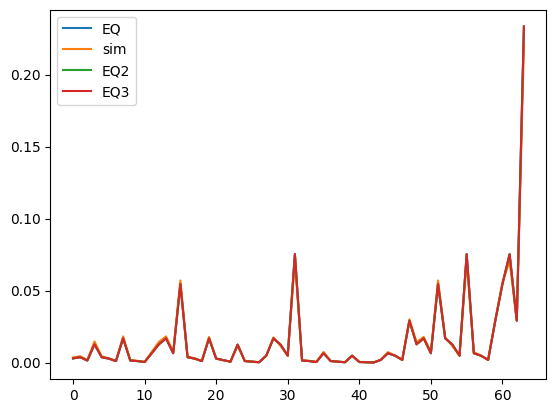

In [48]:
plt.plot(eq_freq_vec_cdn, label='EQ')
plt.plot(result, label='sim')
plt.plot(pi.flatten(), label='EQ2')
plt.plot(pi2.flatten(), label='EQ3')
plt.legend()

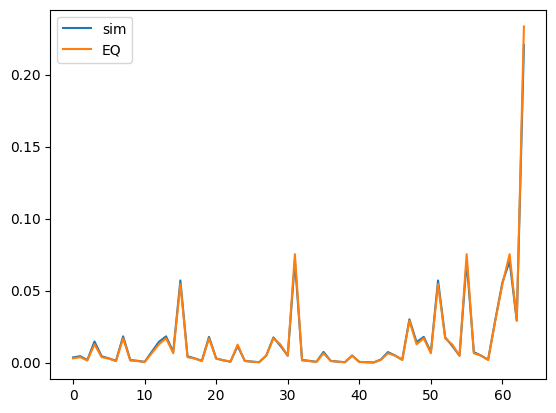

In [49]:
plt.plot(result, label='sim')
plt.plot(eq_freq_vec, label='EQ')
plt.legend()

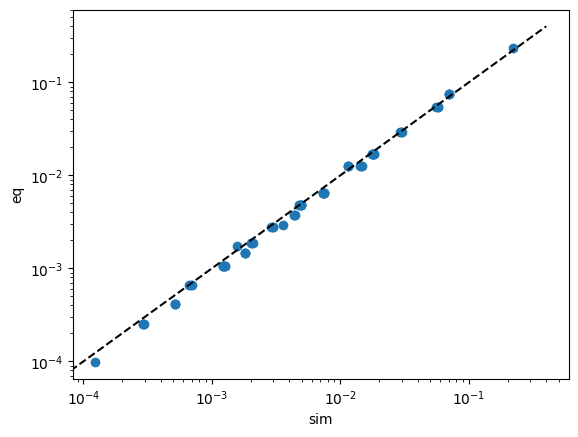

In [50]:
plt.scatter(result, eq_freq_vec)
plt.plot([0, 0.4], [0, 0.4], 'k--')
plt.xlabel('sim')
plt.ylabel('eq')
plt.xscale('log')
plt.yscale('log')

In [51]:
# Run 100 iterations
result = simulate_markov_power(transition_matrix, initial_vector, 1)
print(result)

[0.01719978 0.01315482 0.01231871 0.04009193 0.00909243 0.00471134
 0.00486378 0.01792896 0.01149017 0.00392896 0.00348922 0.01811899
 0.04379624 0.01395602 0.01019252 0.06675954 0.00484656 0.00379414
 0.00287485 0.01787515 0.00361579 0.00191485 0.00133724 0.00672789
 0.002924   0.00122457 0.00127944 0.0054583  0.01657131 0.00561309
 0.00392872 0.02922717 0.01297181 0.00575179 0.00493178 0.02819171
 0.00531696 0.00292519 0.00197365 0.01087748 0.00470893 0.00286633
 0.00182684 0.00884619 0.01992313 0.01021806 0.00528433 0.04661975
 0.04393466 0.01704679 0.01263976 0.05214291 0.020706   0.00684368
 0.00447058 0.03619023 0.0083943  0.00726464 0.00139915 0.03169412
 0.03889469 0.0238949  0.01917556 0.10176765]
